# This Is My 30. Employee Promotion Prediction Project

# Import Required Libraries

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing & splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Evaluation metrics
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,
    classification_report,confusion_matrix,auc,roc_auc_score, roc_curve
)

# Regression Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost
from xgboost import XGBClassifier

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Save the model
import joblib

# Load Dataset

In [2]:
data = pd.read_csv("Employees Promotion.csv")
data.head()

,EmployeeID,Department,Region_Employment,Education Level,Gender,Recruitment Channel,NO_Trainings_LstYear,Age,previous_year_rating,Service Length,Awards,Avg_Training_Score,Is Promoted
0,65438,Sales & Marketing,7,Master's & above,f,sourcing,1,35.0,5.0,8,NO,49.0,NO
1,65141,Operations,22,Bachelor's,m,other,1,30.0,5.0,4,NO,60.0,NO
2,7513,Sales & Marketing,19,Bachelor's,m,sourcing,1,34.0,3.0,7,NO,50.0,NO
3,2542,Sales & Marketing,23,Bachelor's,m,other,2,39.0,1.0,10,NO,50.0,NO
4,48945,Technology,26,Bachelor's,m,other,1,45.0,3.0,2,NO,73.0,NO


# Data Preprocessing

In [3]:
data.shape

(54808, 13)

In [4]:
data.duplicated().sum()

0

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   EmployeeID            54808 non-null  int64  
 1   Department            54808 non-null  object 
 2   Region_Employment     54808 non-null  int64  
 3   Education Level       52399 non-null  object 
 4   Gender                54808 non-null  object 
 5   Recruitment Channel   44404 non-null  object 
 6   NO_Trainings_LstYear  54808 non-null  int64  
 7   Age                   54268 non-null  float64
 8   previous_year_rating  50684 non-null  float64
 9   Service Length        54808 non-null  int64  
 10  Awards                54808 non-null  object 
 11  Avg_Training_Score    52248 non-null  float64
 12  Is Promoted           54808 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 5.4+ MB


In [6]:
data.isna().sum()

EmployeeID                  0
Department                  0
Region_Employment           0
Education Level          2409
Gender                      0
Recruitment Channel     10404
NO_Trainings_LstYear        0
Age                       540
previous_year_rating     4124
Service Length              0
Awards                      0
Avg_Training_Score       2560
Is Promoted                 0
dtype: int64

In [7]:
a = pd.DataFrame()
a['columns'] = list(data.columns)
a['nulls'] = list(data.isna().sum())

for i in a[a['nulls']>500]['columns'].values:
    data.drop(i,axis=1,inplace=True)

In [8]:
data.isna().sum()

EmployeeID              0
Department              0
Region_Employment       0
Gender                  0
NO_Trainings_LstYear    0
Service Length          0
Awards                  0
Is Promoted             0
dtype: int64

In [9]:
data.describe()

,EmployeeID,Region_Employment,NO_Trainings_LstYear,Service Length
count,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,14.195045,1.253011,5.865512
std,22586.581449,10.086273,0.609264,4.265094
min,1.000000,1.000000,1.000000,1.000000
25%,19669.750000,4.000000,1.000000,3.000000
50%,39225.500000,13.000000,1.000000,5.000000
75%,58730.500000,22.000000,1.000000,7.000000
max,78298.000000,34.000000,10.000000,37.000000


In [10]:
cat = data.select_dtypes(include='object')
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].nunique()}")

Department
10
Gender
2
Awards
2
Is Promoted
2


In [11]:
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].unique()}")

Department
['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal' '-']
Gender
['f' 'm']
Awards
['NO' 'YES']
Is Promoted
['NO' 'YES']


In [12]:
data = data.drop(data[data['Department'] == '-'].index)

print(data['Department'].value_counts())

Department
Sales & Marketing    16773
Operations           11304
Procurement           7117
Technology            7113
Analytics             5330
Finance               2525
HR                    2411
Legal                 1035
R&D                    995
Name: count, dtype: int64


# Convert to imbalance dataset to balance dataset

In [13]:
data['Is Promoted'].value_counts()

Is Promoted
NO     49954
YES     4649
Name: count, dtype: int64

In [14]:
max_count = data['Is Promoted'].value_counts().max()
max_count

49954

In [15]:
upsampled_list = []
for cls in data['Is Promoted'].unique():
    cls_data = data[data['Is Promoted'] == cls]
    cls_upsampled = resample(
        cls_data,
        replace=True,
        n_samples=max_count,
        random_state=42
    )
    upsampled_list.append(cls_upsampled)

data_balanced = pd.concat(upsampled_list)
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

data =data_balanced

data['Is Promoted'].value_counts()

Is Promoted
NO     49954
YES    49954
Name: count, dtype: int64

# Encoding

In [16]:
data['Gender'] = data['Gender'].map({'f':0,'m':1})
data['Awards'] = data['Awards'].map({'NO':0,'YES':1})
data['Is Promoted'] = data['Is Promoted'].map({'NO':0,'YES':1})

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99908 entries, 0 to 99907
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   EmployeeID            99908 non-null  int64 
 1   Department            99908 non-null  object
 2   Region_Employment     99908 non-null  int64 
 3   Gender                99908 non-null  int64 
 4   NO_Trainings_LstYear  99908 non-null  int64 
 5   Service Length        99908 non-null  int64 
 6   Awards                99908 non-null  int64 
 7   Is Promoted           99908 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.1+ MB


In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Department'] = le.fit_transform(data['Department'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99908 entries, 0 to 99907
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   EmployeeID            99908 non-null  int64
 1   Department            99908 non-null  int32
 2   Region_Employment     99908 non-null  int64
 3   Gender                99908 non-null  int64
 4   NO_Trainings_LstYear  99908 non-null  int64
 5   Service Length        99908 non-null  int64
 6   Awards                99908 non-null  int64
 7   Is Promoted           99908 non-null  int64
dtypes: int32(1), int64(7)
memory usage: 5.7 MB


# I use sample 20000 Dataset

In [19]:
data = data.sample(n=20000, replace=True, random_state=42)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 15795 to 59426
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   EmployeeID            20000 non-null  int64
 1   Department            20000 non-null  int32
 2   Region_Employment     20000 non-null  int64
 3   Gender                20000 non-null  int64
 4   NO_Trainings_LstYear  20000 non-null  int64
 5   Service Length        20000 non-null  int64
 6   Awards                20000 non-null  int64
 7   Is Promoted           20000 non-null  int64
dtypes: int32(1), int64(7)
memory usage: 1.3 MB


# Heatmap

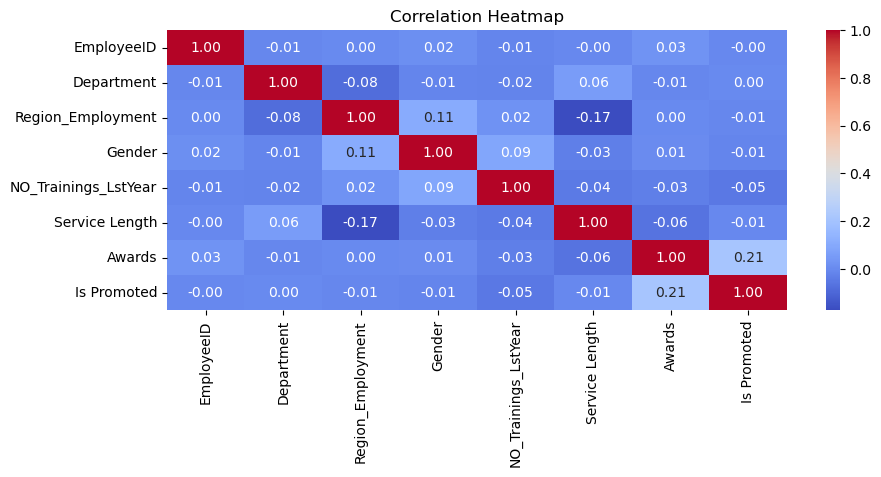

In [20]:
plt.figure(figsize=(34,8))
plt.subplot(2,3,2)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show();

# Is Promoted Distribution

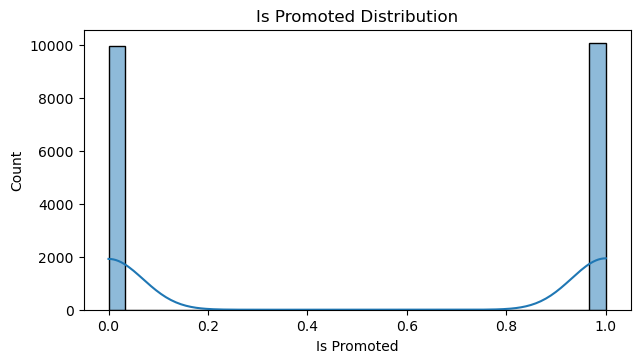

In [21]:
plt.figure(figsize=(24,8))
plt.subplot(2,3,1)
sns.histplot(data['Is Promoted'], kde=True, bins=30)
plt.title('Is Promoted Distribution')
plt.show();

# Feature Relationships with Is promoted

<Figure size 1400x800 with 0 Axes>

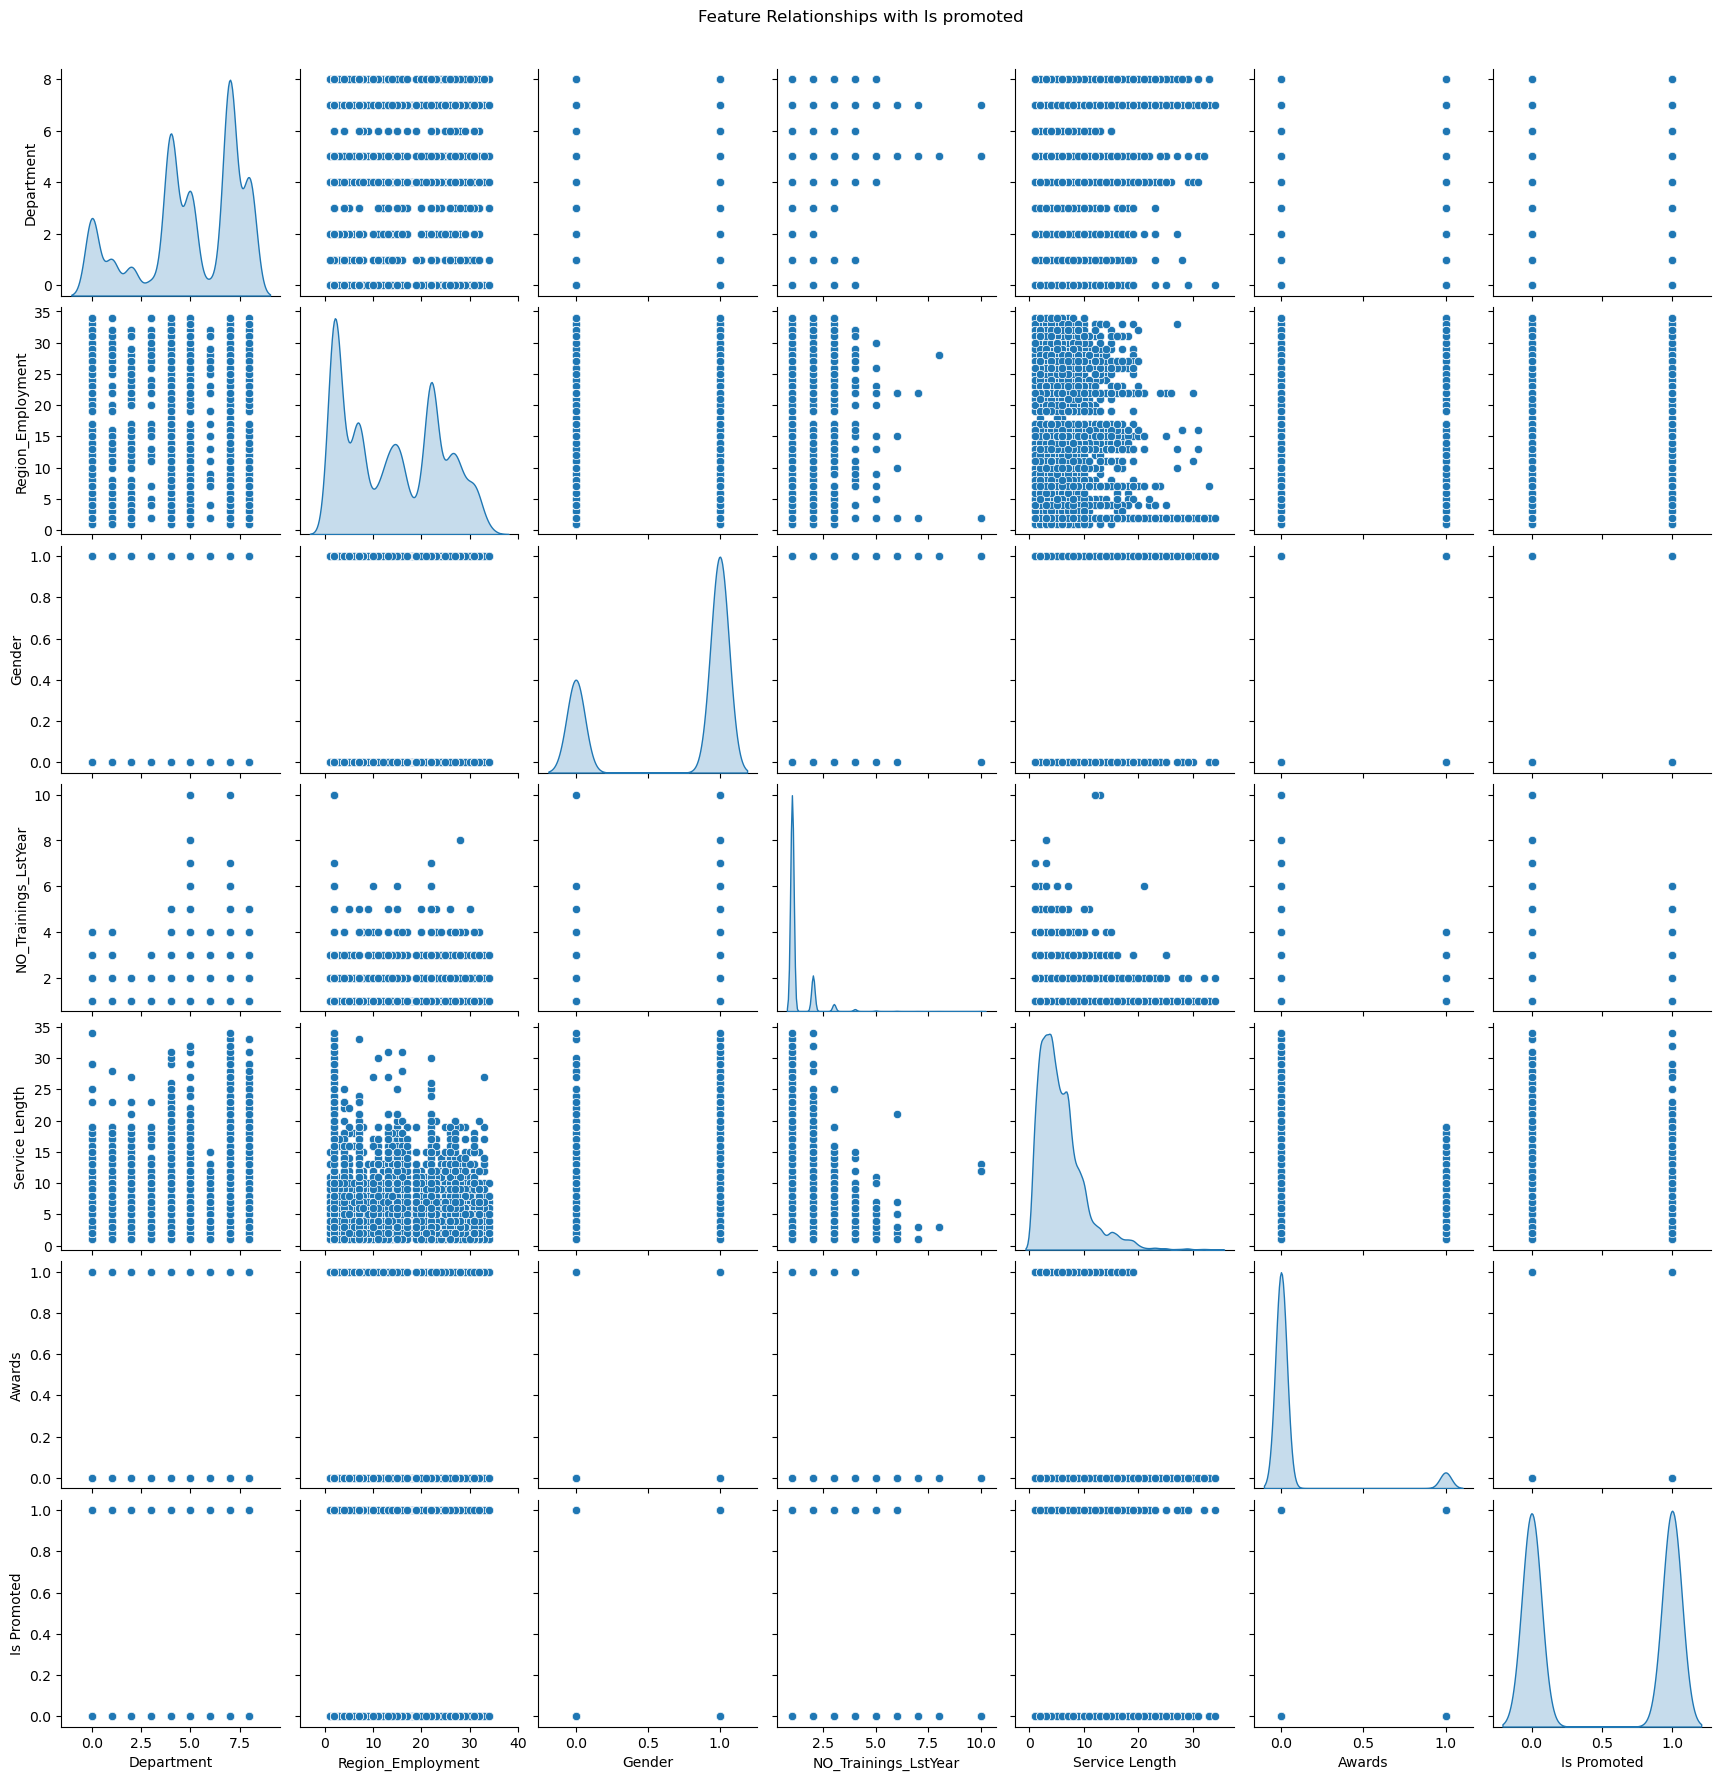

In [28]:
plt.figure(figsize=(14,8))
sns.pairplot(data[['Department', 'Region_Employment', 'Gender',
       'NO_Trainings_LstYear', 'Service Length', 'Awards', 'Is Promoted']], diag_kind='kde')
plt.suptitle("Feature Relationships with Is promoted", y=1.02)
plt.show();

# Splitting for Target and Feature into Train Test Split

In [22]:
X = data.drop(['Is Promoted','EmployeeID'],axis=1)
y = data['Is Promoted']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Preprocessing pipeline

In [23]:
preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Define models & parameter grids for classification

In [24]:
models = {
    # -------------------------------
    "Logistic Regression": {
        "model": LogisticRegression(solver='lbfgs', max_iter=500, random_state=42),
        "param_grid": {
            "C": [0.1, 1, 10],
            "penalty": ['l2']
        }
    },
    # -------------------------------
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "param_grid": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    # -------------------------------
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    # -------------------------------
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    # -------------------------------
    "Extra Trees": {
        "model": ExtraTreesClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "p": [1, 2]  # Manhattan (L1) or Euclidean (L2)
        }
    },
    # -------------------------------
    "MLP Classifier": {
        "model": MLPClassifier(random_state=42),
        "param_grid": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu", "tanh"],
            "solver": ["adam"],
            "max_iter": [200]
        }
    },
    # -------------------------------
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    }
}

print(f" Total Models Loaded: {len(models)}")

 Total Models Loaded: 9


# Model Evaluation Run GridSearchCV for each classification 

In [25]:
results = []
best_score = -float('inf')
best_model = None
best_name = None

# Run GridSearchCV for each classification model
for name, mp in models.items():
    print(f"\n Running GridSearchCV for {name}...")
    grid = GridSearchCV(mp['model'], param_grid=mp['param_grid'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

    print(f"{name} Best CV Score (Accuracy): {grid.best_score_:.4f}")
    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")


    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

# Output summary
results_df = pd.DataFrame(results)
print("\n Summary Results:")
print(results_df)

print(f"\n Best Model: {best_name}")
print(f" Best CV Score (Accuracy): {best_score:.4f}")


 Running GridSearchCV for Logistic Regression...
Logistic Regression Best CV Score (Accuracy): 0.5496
Logistic Regression Best Params: {'C': 1, 'penalty': 'l2'}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.97      0.68      1966
           1       0.83      0.14      0.24      2034

    accuracy                           0.55      4000
   macro avg       0.68      0.56      0.46      4000
weighted avg       0.68      0.55      0.46      4000


 Running GridSearchCV for Decision Tree...
Decision Tree Best CV Score (Accuracy): 0.6959
Decision Tree Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1966
           1       0.71      0.72      0.71      2034

    accuracy                           0.71      4000
   macro avg       0.71     

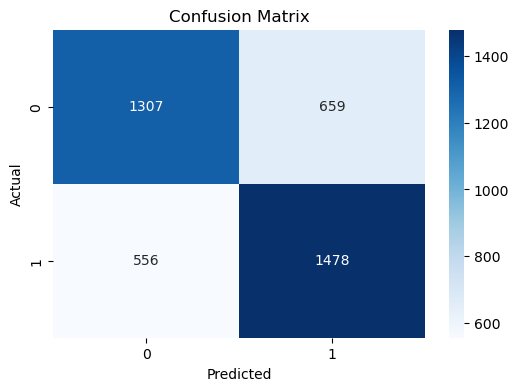

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save The Model

In [29]:
feature_columns = X.columns.to_list()
joblib.dump(feature_columns,'Employee Promotion Prediction.joblib')

['Employee Promotion Prediction.joblib']

In [30]:
joblib.dump(best_model,'bestmodel Employee Promotion Prediction.joblib')

['bestmodel Employee Promotion Prediction.joblib']

# If you have any suggestions, please DM me.
# Even a small message from you can make a big impact on my career
#### I am Arun